In [ ]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using ForwardDiff;

In [ ]:
#Hyperparameters
n = 40
N = 160
σₐ = 0.002
k_range = 12
k_list = [i for i in 1:k_range];

In [ ]:
#Functions
function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    #bₕ = reshape(zeros(k), k)
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
    #bₒ = 0.0
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

function sigmoid(x::Array{Float64}, a=10)
    return 1.0 ./ (1.0 .+ a.*exp.(-x))
end

function sigmoid(x::Float64, a=10)
    return 1.0/(1.0 + a*exp(-x))
end


#function sigmoid(x::ForwardDiff.Dual)
    #sx = sigmoid(x.value)
    #return ForwardDiff.Dual(sx, sx*(one(sx)-sx)*x.partials)
#end

function hardσ(x, a=2.0)
    max(0, min(1.0, a * x + 0.5))
end
    
#function sigmoid(x::Float64, a=1)
    #return 1.0 / 1.0 + a*exp(-x)
#end

mₖ(k) = k*4 + 1

#Test out the unpack method
k = 5
m = mₖ(k)
θtest = [i for i=1:m]
a,b,c,d = unpack(θtest,k);

In [ ]:
#Generate XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [0.25, 0.25]
    μ₂ = [0.25, 0.75]
    μ₃ = [0.75, 0.75]
    μ₄ = [0.75, 0.25]
    #μ₅ = [1.25, 1.25]
    #μ₆ = [1.25, 1.75]
    #μ₇ = [1.75, 1.75]
    #μ₈ = [1.75, 1.25]
    μ = [μ₁, μ₂, μ₃, μ₄]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

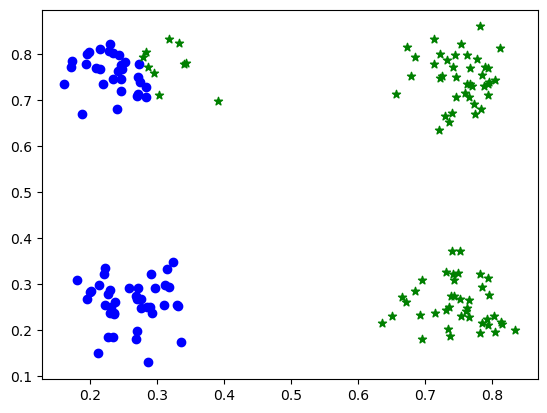

In [34]:
#Bayesian Neural Net
function G(x, Θ::AbstractVector, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    W₁, b₁, W₂, b₂ = unpack(Θ,k)
    nn = Chain(Dense(W₁, b₁, tanh),
               Dense(W₂, [b₂]))
    return nn(x)
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

@gen function classifier(x::Array{Float64})
    σₖ = 10.0::Float64
    
    # Create the weight and bias vector.
    #k ~ uniform_discrete(1,k_range)
    #k ~ k_count(1,0.5,1)
    k = 2
    m = mₖ(k)
    μ = zeros(m)
    Σ = Diagonal([σₖ for i=1:m])
    Θ ~ mvnormal(μ,Σ) #Coefficients of the polynomial
    
    #Return Network Scores for X
    scores = Flux.σ.(G(x,Θ,k))
    #scores = Flux.σ.((scores .- 0.5) * 1000)
    
    #Logistic Regression Likelihood
    y = zeros(length(x[1,:])) #Array to fill with class labels
    for j=1:N
        y[j] = @trace(normal(scores[j]*1 + (1-scores[j])*0, 0.5), (:y,j))
    end
    return scores
    
    #Logistic Regression Likelihood
    #y = zeros(length(x[1,:])) #Array to fill with class labels
    #for j=1:N
        #y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    #end
    #return y
end;

predictions = classifier(data)
preds = data_labeller(predictions)
plot_data(data_raw,preds)

In [35]:
#Register Observed Data - Bernoulli
obs = choicemap()::ChoiceMap
for j in 1:length(classes)
    obs[(:y, j)] = classes[j] - 1
end;
#print(obs)

In [ ]:
#Register Observed Data - Normal
obs = choicemap()::ChoiceMap
for j in 1:length(classes)
    obs[(:y, j)] = 0.0
end;

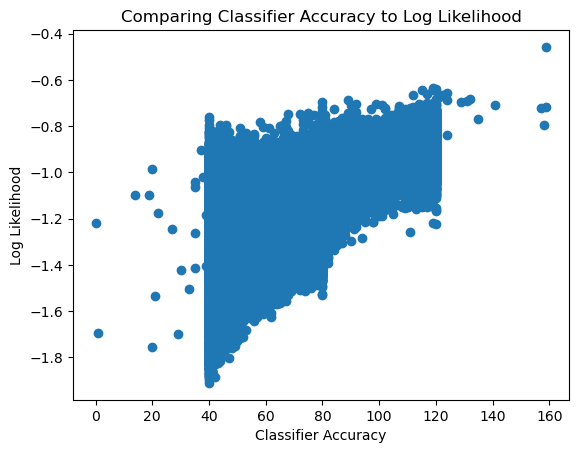

In [36]:
#Plot of Log Likelihood Scores
scores = []
accs = []
nans = []
(best_trace,) = generate(classifier, (data,), obs)
best_score = get_score(best_trace)/length(classes)
best_Θ = best_trace[:Θ]
#best_k = best_trace[:k]
best_k = 2
#print(best_k)

best_pred_y = G(data,best_Θ,best_k)
best_pred_labels = data_labeller(best_pred_y)
best_acc = sum([best_trace[(:y,i)] == best_pred_labels[i] for i=1:length(classes)])/length(classes)

for i in 1:100000
    (trace,) = generate(classifier, (data,), obs)

    #y = to_array(choice_gradients(trace,select(:Θ),nothing)[3], Float64)
    #nan = sum([isnan(i) for i in y])
    #if nan == 6
        #nan = 1
    #end
    #push!(nans, nan)
    
    Θ = trace[:Θ]
    #k = trace[:k]
    k=2
    pred_y = G(data,Θ,k)
    pred_labels = data_labeller(pred_y)
   #print(pred_y)
    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    score = get_score(trace)/length(classes)
    if acc > best_acc
        best_score = score
        best_trace = trace
        best_acc = acc
        best_pred_labels = pred_labels
    end
    push!(scores,score)
    push!(accs,acc)
end

#colors = ["green","red"]

#for i=1:2
    #mask = [nans[j]+1 == i for j in 1:length(nans)]
    #scatter(accs[mask],scores[mask],c=colors[i],zorder=3-i)
#end

#print(sum(nans))

scatter(accs,scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");

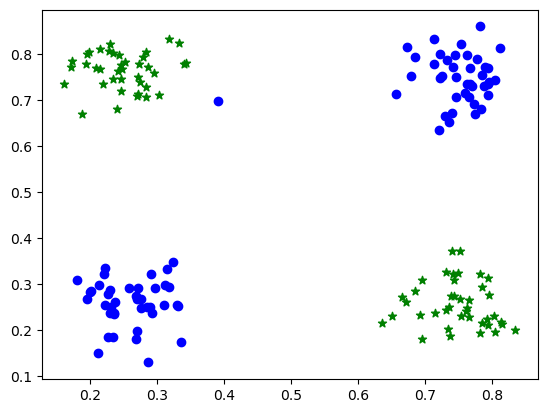

2


In [37]:
#Test out best parameterization
test_scores = sigmoid(G(data,best_Θ,best_k),1)
predictions = data_labeller(test_scores)
plot_data(data_raw,best_pred_labels)
#print(best_Θ)
#print(best_acc)
println(best_k)

In [ ]:
#Homebrew MCMC
iterations = 200000
burnin = 2000

#Make initial trace
(trace,) = generate(classifier, (data,), obs)
traces = []
accepted = []
scores = []
for i=1:iterations
    (trace2,) = generate(classifier, (data,), obs)
    score1 = exp(get_score(trace)/length(classes))
    score2 = exp(get_score(trace2)/length(classes))
    
    score = score2/score1
    
    if score > 1
        trace = trace2
        acc = 1
        push!(scores, score2)
    else
        if score > rand(Uniform(0,1))
            trace = trace2
            acc = 1
            push!(scores, score2)
        else
            acc = 0
            push!(scores, score1)
        end
    end
    if i%10000 == 0    
        println("Epoch $i Acceptance Prob: $(sum(accepted)/length(accepted))")
    end
    push!(accepted, acc)
    if i%1 == 0
        push!(traces, trace)
    end
end

print(sum(accepted)/length(accepted))

In [ ]:
#Bar Plot of k estimates
ks = [traces[i][:k] for i in 1:length(traces)]
counts = [sum([ks[i] == j for i in 1:length(ks)]) for j in k_list]
barlist=bar(k_list,counts)
for i in 1:k_range
    barlist[i].set_color([0.8,0.0,0.0])
end
barlist[2].set_color([0.0,0.8,0.1])

plt.title("Counts of Values for k from MCMC Trace - Negative Binomial Prior")
plt.xlabel("k value")
plt.ylabel("Occurences");

In [ ]:
#Metropolis-Hastings finally works!
function mh_inference(iters)
    (trace,) = generate(classifier, (data,), obs)
    acc = []
    traces = []
    for i=1:iters
        (trace, accepted) = mh(trace, select(:k,:Θ), check=false, observations=obs)
        push!(traces, trace)
        push!(acc, accepted)
        if i%10000 == 0
            println(sum(accepted)/length(accepted))
        end
    end
    return traces, acc
end

traces, accepted = mh_inference(100000)
scores = [get_score(trace) for trace in traces];

In [ ]:
old_traces = traces
print(old_traces[16000])

In [ ]:
function sample_momenta(n::Int)
    Float64[random(normal, 0, 1) for _=1:n]
end

function assess_momenta(momenta)
    logprob = 0.
    for val in momenta
        logprob += Gen.logpdf(normal, val, 0, 1)
    end
    logprob
end

In [ ]:
trace = old_traces[16000]
selection = select(:Θ)
L = 1
eps = 0.01
observations = obs

prev_model_score = get_score(trace)

args = get_args(trace)
retval_grad = accepts_output_grad(get_gen_fn(trace)) ? zero(get_retval(trace)) : nothing
argdiffs = map((_) -> NoChange(), args)

#Leapfrog
new_trace = trace
(_, values_trie, gradient_trie) = choice_gradients(new_trace, selection, retval_grad)
values2 = to_array(values_trie, Float64)
gradient = to_array(gradient_trie, Float64)
print(gradient)
momenta = sample_momenta(length(values2))
prev_momenta_score = assess_momenta(momenta)

for step=1:L
    momenta += (eps/2) * gradient
    values2 += eps * momenta
    #print(values2)
    
    values_trie = from_array(values_trie, values2)
    #print(values_trie)
    (new_trace, _, _) = update(new_trace, args, argdiffs, values_trie)
    (_,_,gradient_trie) = choice_gradients(new_trace, selection, retval_grad)
    gradient = to_array(gradient_trie, Float64)
    print(gradient)
    
    momenta = (eps/2) * gradient
end

In [54]:
function hmc_inference(starting_trace, iters)
    (trace,) = generate(classifier, (data,), obs)
    #trace = starting_trace
    acc = []
    traces = []
    for i=1:iters
        (trace, accepted) = hmc(trace, select(:Θ), L=10, eps=0.18, check=false, observations=obs)
        push!(traces, trace)
        push!(acc, accepted)
        if i%500 == 0
            println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
        end
    end
    return traces, acc
end

hmc_traces, accepted = hmc_inference(best_trace,20000);

Epoch 500 Acceptance Prob: 0.3
Epoch 1000 Acceptance Prob: 0.256
Epoch 1500 Acceptance Prob: 0.2693333333333333
Epoch 2000 Acceptance Prob: 0.246
Epoch 2500 Acceptance Prob: 0.2572
Epoch 3000 Acceptance Prob: 0.258
Epoch 3500 Acceptance Prob: 0.25971428571428573
Epoch 4000 Acceptance Prob: 0.2745
Epoch 4500 Acceptance Prob: 0.27755555555555556
Epoch 5000 Acceptance Prob: 0.2784
Epoch 5500 Acceptance Prob: 0.28036363636363637
Epoch 6000 Acceptance Prob: 0.2811666666666667
Epoch 6500 Acceptance Prob: 0.28523076923076923
Epoch 7000 Acceptance Prob: 0.2844285714285714
Epoch 7500 Acceptance Prob: 0.2846666666666667
Epoch 8000 Acceptance Prob: 0.28625
Epoch 8500 Acceptance Prob: 0.28541176470588236
Epoch 9000 Acceptance Prob: 0.2841111111111111
Epoch 9500 Acceptance Prob: 0.28568421052631576
Epoch 10000 Acceptance Prob: 0.2863
Epoch 10500 Acceptance Prob: 0.2834285714285714
Epoch 11000 Acceptance Prob: 0.2809090909090909
Epoch 11500 Acceptance Prob: 0.28052173913043477
Epoch 12000 Acceptance

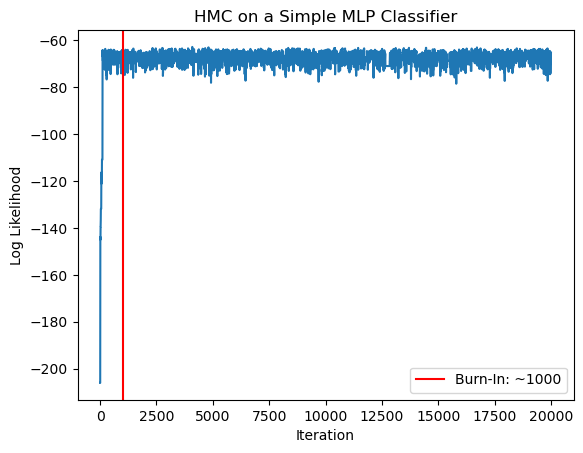

In [55]:
scores = [get_score(i) for i in hmc_traces]
plot(scores)
plt.title("HMC on a Simple MLP Classifier")
plt.xlabel("Iteration")
plt.ylabel("Log Likelihood")
plt.axvline(1000,label="Burn-In: ~1000",color="red")
plt.legend();

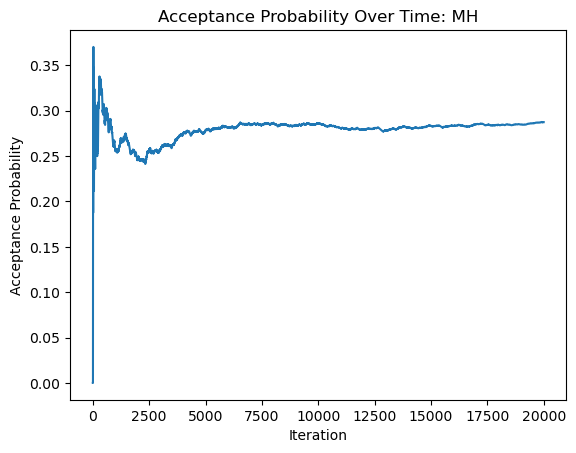

PyObject Text(24.00000000000002, 0.5, 'Acceptance Probability')

In [56]:
#Acceptance Probability Over Time
acc = [sum(accepted[1:i])/i for i in 1:length(accepted)]
plot(acc)
plt.title("Acceptance Probability Over Time: MH")
plt.xlabel("Iteration")
plt.ylabel("Acceptance Probability")

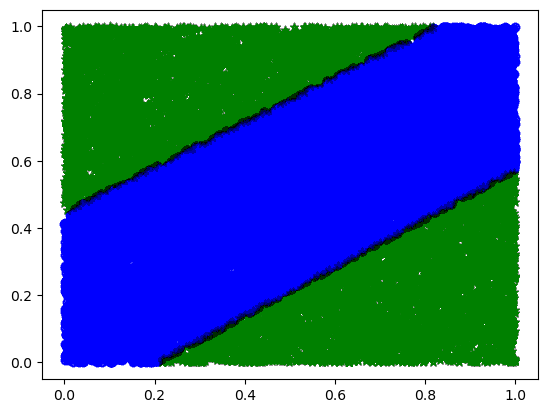

In [57]:
thetas = [trace[:Θ] for trace in hmc_traces]
x_grid = zeros((20000,2));
for i=1:20000
    x_grid[i,:] = rand(1,2)
end
x_grid2 = transpose(x_grid)
grid_preds = G(x_grid2,thetas[1900],2)
grid_labels = data_labeller(grid_preds)
plot_data(x_grid,grid_labels,0.01)

i = 
for i=1:100
    index = rand(2000:20000)
    grid_preds = G(x_grid2,thetas[1900],2)
    grid_labels = data_labeller(grid_preds)
    plot_data(x_grid,grid_labels,0.01)
end
#print(best_trace[:Θ])
#trace = hmc_traces[1000]

#y = to_array(choice_gradients(best_trace,select(:Θ),nothing)[3], Float64)
#[isnan(i) for i in y]

